In [1]:
# LangGraph
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# LangChain
from langchain.graphs import Neo4jGraph
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage

# LangSmith
from langsmith import traceable

# General
import os
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from IPython.display import Image, display

# Get environment variables
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="gemma2-9b-it")
# model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="mixtral-8x7b-32768")
# graph = Neo4jGraph()

###############

supervisor_prompt = """Your Identity: You are a personality chief scientist running a career recommendation system.\
System's Goal: The goal of this system is to conduct a personality test (ask the person questions), extract personality traits from the person's answers and recommend the person careers suitable to their personality traits. Note: the system is a conversational flow with a person.\
Tools: Your system has a tool that allows you to query a knowledge graph to supplement your recommendations.\
Your task: You will decide which step to take next in the system's workflow.\
Steps that you can take: ask question, extract traits, query knowledge graph, recommend careers, and wait for person to answer.\
Ideal workflow: ask questions, receive person's answer, extract traits, ask another question ... Whenever you are ready to recommend suggestions, query the graph, then recommend careers.
Summary: you are the chief scientist managing the system's workflow. Your system should ask a question and extract traits. Query the knowledge when necessary and return recommendations when you are ready."""

questioner_prompt = """You are an expert personality scientist. \
You will conduct a personality test using the RAISEC personality model \
The test will be a real-time conversational flow\
Your task is to ask questions to uncover personality traits that are related to career tracks. \
Number your questions and make sure to limit your test to 2 questions.\
Make your questions concise.\
You can only ask one question per message, do not give one question for every trait per message.\
Conclude your response with Questions Remaining: (number of questions you still want to ask). You can always adjust the number of questions you want to ask based on your need.\
Example Output: Do you prefer alone time or crowded places? Questions Remaining: 0"""

trait_extractor_prompt = """
  Your Message: {question}\
  Person's Message: {answer}\
  Task: Analyze the person's message to identify personality traits. Extract the person's traits, both the negative and the positive. Include what they are interested in, characteristics, and style in a detailed and descriptive way that is not redundant. Return them as keywords separated by commas in the format trait1, trait2, trait3, ... .\
  Rules for your output: Ensure the output is strictly in the specified format and don't add any explanation to your output.\
  
  Example Person answer => 'I like to go with the flow and see what happens'\
  Wrong output format => Final Answer: The final answer is "spontaneous, flexible, adaptable". I hope it is correct.\
  Correct Output Format: adaptable, casual tone\
  Reminder, do not explain or add anything other than the string of keywords.\
  Note: make the keywords descriptive and specific.\
"""

###############


class AgentState(TypedDict):
  # Saves the history messages
  messages: Annotated[list[AnyMessage], operator.add]
  
  # When user answers a wuestion, we want the LLM to transform the message into a string of keywords representing descriptive personality traits
  extracted_traits: Annotated[list[str], operator.add]
  
  # When LLM queries the knowledge graph, we want it to select only what it needs and store them in a list
  queried_ocupations: Annotated[list[str], operator.add]
  
  # When LLM queries the knowledge graph, we want it to keep the info of paramerer values that it found in the graph
  graph_details: Annotated[dict, operator.add]

  # Store the history of steps taken so far
  steps_taken: Annotated[list, operator.add]

  

###############


class Agent:
  def __init__(self, model, tools, system):
    
    # Initialize Variables
    self.system = system
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)
    memory = MemorySaver()
    graph_builder = StateGraph(AgentState)

    # Create Nodes
    graph_builder.add_node('supervisor', self.supervisor_node)
    graph_builder.add_node('ask_question', self.questioner_node)
    graph_builder.add_node('extract_traits', self.trait_extractor_node)
    graph_builder.add_node('recommend_careers', self.career_recommender_node)
    
    # Create Edges
    graph_builder.set_entry_point('supervisor')
    graph_builder.add_conditional_edges('supervisor', self.next_route, 
                                        {
                                          0: END, 
                                          1: 'ask_question', 
                                          2: 'extract_traits', 
                                          3: 'recommend_careers'
                                          # 3: 'query_graph', 
                                          })
    graph_builder.add_edge('ask_question', 'supervisor')
    graph_builder.add_edge('extract_traits', 'supervisor')
    graph_builder.add_edge('recommend_careers', END)

    # Compile and Displat Graph
    self.graph = graph_builder.compile(checkpointer=memory)
    display(Image(self.graph.get_graph().draw_mermaid_png()))
  
  ## Supervisor will choose what to do next
  @traceable
  def supervisor_node(self, state: AgentState):
    steps_taken = state['steps_taken']

    # If the last step is to ask a question -> wait for person to answer
    if steps_taken[-1] == 'ask_question':
      return {'steps_taken': ['wait_for_person_to_answer']}
    
    # After every time the person sends a message, it will be interpretted and traits extracted
    elif steps_taken[-1] == 'person_sent_a_message':
      return {'steps_taken': ['extract_traits']}
  
    # Otherwise, let the supervisor decide
    else: 
      progress_context = f"""Context of your system's progress:\
        Steps taken so far: {steps_taken}\
        Extracted traits: {state['extracted_traits']}\
        Queried occupations: {state['queried_ocupations']}\
        Graph details: {state['graph_details']}\
        """
      task = "Now you will choose the next step to take.\
        You will return one of the following options as they are and without explanation or added texts.\
        Options: ask_question - extract_traits - wait_for_person_to_answer - recommend_careers\
        "
      
      prompt = [
        SystemMessage(content=self.system), 
        HumanMessage(content=f"{progress_context, task}")
        ]

      # The supervisor's decision on what to do next
      next_step = self.model.invoke(prompt)
      return {'steps_taken': [next_step.content]}

  ## Conditional edge that takes us to the next step based on the Supervisor's decision (state['steps_taken']).
  def next_route(self, state: AgentState):
    next_step = state['steps_taken'][-1]

    if next_step == 'wait_for_person_to_answer': return 0
    elif next_step == 'ask_question': return 1
    elif next_step == 'extract_traits': return 2
    # elif next_step == 'query_graph': return 3
    elif next_step == 'recommend_careers': return 4

  ## LLM that asks a question
  def questioner_node(self, state: AgentState):

    # Make sure that the first message is the questioner_prompt
    messages = [SystemMessage(content=questioner_prompt)] + state['messages']

    # Give the model the history of messages
    ai_response = self.model.invoke(messages)
    return {'messages': [ai_response]} # add the new AI_Message to the AgentState

  ## Ask the model to extract traits
  def trait_extractor_node(self, state: AgentState):
    
    ai_question = None
    user_message = None
    
    if len(state['messages']) == 1:
      user_message = state['messages'][0].content
      ai_question = "Greetings"
    
    # Get the previous question. NOTE:loop starts at -2, since at this point the AI asked a new question, but we are looking for the previous one.
    # NOTE: When looping, we will come across the human message before the AI message
    else:  
      for i in range(-1, -len(state['messages']), -1):
        message = state['messages'][i]
        # Get person's response
        if message.type == 'human':
          user_message = state['messages'][i].content
        # Get previous AI question
        if message.type == 'ai':
          ai_question = state['messages'][i].content
          break
    
    # Give the user's answer to the model to extract traits from it
    message = [SystemMessage(content=trait_extractor_prompt.format(answer=user_message, question=ai_question))]
    response = self.model.invoke(message)

    return {'extracted_traits': [response.content], 'steps_taken': ['extracted_traits_from_answer']}

  def career_recommender_node(self, state: AgentState):
    print("---oops----- In career recommender node ---------")
    return


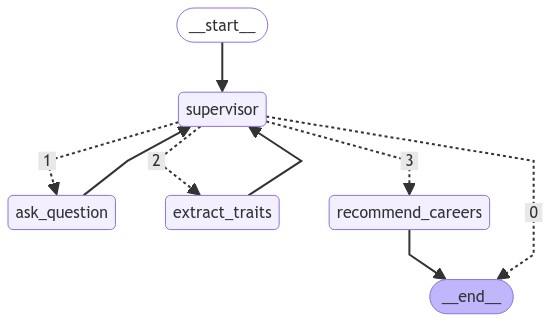

In [2]:
# graph = Neo4jGraph()
# print("Connected to graph")

# @tool
# def query_graph(query):
#   """Query from Neo4j knowledge graph using Cypher."""
#   return graph.query(query)

# @tool
# def toggle_query_graph(query):
#   """Change AgentState variable called """
#   return graph.query(query)

model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")
agent = Agent(model=model, tools=[], system=supervisor_prompt)

In [5]:
thread = {'configurable': {'thread_id': "12"}}

m = []
for message in agent.graph.stream({"messages": [HumanMessage(content="intuition and instincts")], 'steps_taken': ['person_sent_a_message']}, thread, stream_mode='values'):
    m.append(message['messages'][-1])

print(m[-1].content)

Based on your responses, here's a brief summary of your RAISEC personality traits:

* You tend to be more of an Artistic (A) type, preferring to go with the flow and being open to new experiences.
* You also seem to have a strong Intuitive (N) component, relying on your intuition and instincts when making decisions.

These traits may suggest that you'd thrive in careers that value creativity, flexibility, and innovation, such as artistic or design-related fields, social entrepreneurship, or roles that involve exploring new possibilities.

Please note that this is a limited assessment, and a full RAISEC test would require more questions to provide a more detailed and accurate personality profile.


In [117]:
# for message in agent.graph.get_state(thread).values['messages']:
#   print(f"--{message.type}--> {message.content}\n")

# print(agent.graph.get_state(thread).values['messages'][-1].content)

print(" ".join(m[-1].content.split()[-3:]))

Questions Remaining: 1


In [6]:
print(f"extracted_traits: {agent.graph.get_state(thread).values['extracted_traits']}\n")
print(f"queried_ocupations: {agent.graph.get_state(thread).values['queried_ocupations']}\n")
print(f"graph_details: {agent.graph.get_state(thread).values['graph_details']}\n")
print(f"steps_taken: {agent.graph.get_state(thread).values['steps_taken']}\n")

extracted_traits: ['friendly, polite, brief, simple, casual', 'spontaneous, flexible, adaptable, easy-going, relaxed, open-minded, unconstrained', 'trustworthy, instinctual, impulsive, emotional, spontaneous, non-analytical, open-minded, unconventional, free-spirited']

queried_ocupations: []

graph_details: {}

steps_taken: ['person_sent_a_message', 'extract_traits', 'extracted_traits_from_answer', 'ask_question', 'wait_for_person_to_answer', 'person_sent_a_message', 'extract_traits', 'extracted_traits_from_answer', 'ask_question', 'wait_for_person_to_answer', 'person_sent_a_message', 'extract_traits', 'extracted_traits_from_answer', 'ask_question', 'wait_for_person_to_answer']

